### Hozefa Lakdawala
### Amit Luhar
### Abha Chaudhary

The usual, Imports

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchsummary import summary

Displaying the graph

In [2]:
def plot_the_graph(train_losses,val_losses,train_accuracies,val_accuracies,num_epochs):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', color='magenta')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Loading and PreProcessing the Data

In [3]:
train_path = "FER-13/train"
test_path = "FER-13/test"


In [4]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)

In [6]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


In [7]:
batch_size = 256
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


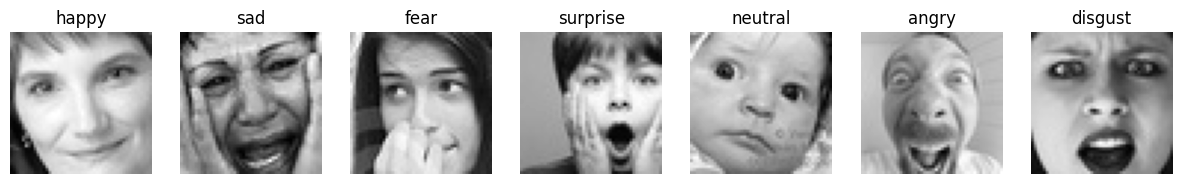

In [8]:
classes = os.listdir(train_path)
fig, axs = plt.subplots(1, 7, figsize=(15, 5))
for i, class_name in enumerate(classes):
    img_path = os.path.join(train_path, class_name, os.listdir(os.path.join(train_path, class_name))[0])
    img = Image.open(img_path)
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(class_name)
    axs[i].axis('off')
plt.show()

Creating the Model

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7,dropout=False):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        if dropout:
            self.dropout = torch.nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

To use dropout and other regularization techniques, set the paramaters in the model

In [10]:
model = SimpleCNN(dropout=False).to(device)
print(model)
# summary(model,(1,256 * 3 * 3, 1024))

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
)


Training Simple CNN model

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data,1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    return train_losses,val_losses,train_accuracies,val_accuracies

In [13]:
n_epochs = 20
train_losses,val_losses,train_accuracies,val_accuracies = train_model(model, train_loader, val_loader, criterion,optimizer, num_epochs=n_epochs)

Epoch 1/20, Train Loss: 1.8378, Val Loss: 1.8180, Train Acc: 0.2347, Val Acc: 0.2268
Epoch 2/20, Train Loss: 1.8075, Val Loss: 1.7971, Train Acc: 0.2565, Val Acc: 0.2334
Epoch 3/20, Train Loss: 1.7867, Val Loss: 1.7893, Train Acc: 0.2574, Val Acc: 0.2375
Epoch 4/20, Train Loss: 1.7473, Val Loss: 1.6921, Train Acc: 0.2794, Val Acc: 0.3034
Epoch 5/20, Train Loss: 1.6246, Val Loss: 1.5659, Train Acc: 0.3574, Val Acc: 0.3859
Epoch 6/20, Train Loss: 1.5335, Val Loss: 1.5296, Train Acc: 0.4005, Val Acc: 0.3971
Epoch 7/20, Train Loss: 1.4824, Val Loss: 1.4454, Train Acc: 0.4195, Val Acc: 0.4364
Epoch 8/20, Train Loss: 1.4287, Val Loss: 1.4087, Train Acc: 0.4452, Val Acc: 0.4497
Epoch 9/20, Train Loss: 1.3843, Val Loss: 1.3783, Train Acc: 0.4654, Val Acc: 0.4692
Epoch 10/20, Train Loss: 1.3412, Val Loss: 1.3269, Train Acc: 0.4827, Val Acc: 0.4915
Epoch 11/20, Train Loss: 1.2994, Val Loss: 1.3049, Train Acc: 0.5019, Val Acc: 0.4939
Epoch 12/20, Train Loss: 1.2643, Val Loss: 1.2880, Train Acc: 0

Displaying the Graph

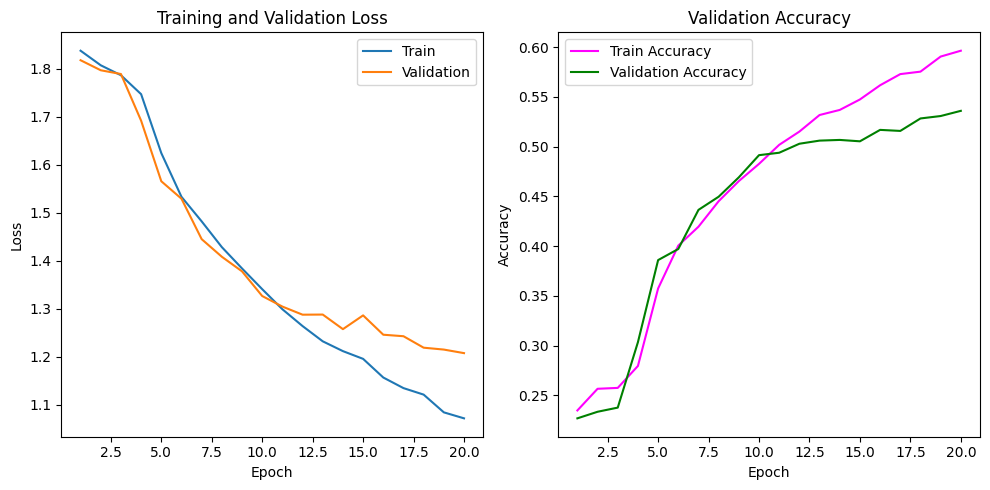

In [14]:
plot_the_graph(train_losses=train_losses,val_losses=val_losses,train_accuracies=train_accuracies,val_accuracies=val_accuracies,num_epochs=n_epochs)

Evaluating the simple cnn model on Test dataset

In [15]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print(f"Test Accuracy: {test_accuracy:.4f}")

In [16]:
test_model(model, test_loader)

Test Accuracy: 0.5332


Saving the Model

In [17]:
model_path = "simple_cnn_model.pth"
torch.save(model.state_dict(),model_path)

Training the Model with droupouts and adam optimizer

In [18]:
model = SimpleCNN(dropout=True).to(device)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0005)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
n_epochs = 20
train_losses,val_losses,train_accuracies,val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer_adam, num_epochs=n_epochs)

Epoch 1/20, Train Loss: 1.8228, Val Loss: 1.8069, Train Acc: 0.2410, Val Acc: 0.2268
Epoch 2/20, Train Loss: 1.7816, Val Loss: 1.7451, Train Acc: 0.2560, Val Acc: 0.2682
Epoch 3/20, Train Loss: 1.6641, Val Loss: 1.5703, Train Acc: 0.3330, Val Acc: 0.3744
Epoch 4/20, Train Loss: 1.5307, Val Loss: 1.4616, Train Acc: 0.3989, Val Acc: 0.4215
Epoch 5/20, Train Loss: 1.4419, Val Loss: 1.4032, Train Acc: 0.4370, Val Acc: 0.4437
Epoch 6/20, Train Loss: 1.3818, Val Loss: 1.3412, Train Acc: 0.4635, Val Acc: 0.4904
Epoch 7/20, Train Loss: 1.3100, Val Loss: 1.3307, Train Acc: 0.4958, Val Acc: 0.4772
Epoch 8/20, Train Loss: 1.2730, Val Loss: 1.2699, Train Acc: 0.5144, Val Acc: 0.5152
Epoch 9/20, Train Loss: 1.2338, Val Loss: 1.2586, Train Acc: 0.5320, Val Acc: 0.5131
Epoch 10/20, Train Loss: 1.2160, Val Loss: 1.2646, Train Acc: 0.5386, Val Acc: 0.5131
Epoch 11/20, Train Loss: 1.1852, Val Loss: 1.2269, Train Acc: 0.5500, Val Acc: 0.5371
Epoch 12/20, Train Loss: 1.1577, Val Loss: 1.2017, Train Acc: 0

Displaying the Graph with adam

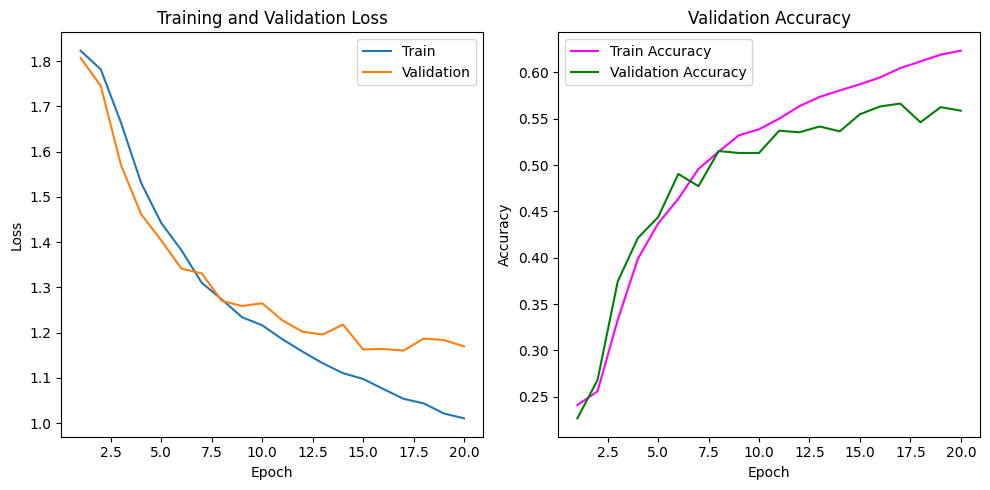

In [20]:
plot_the_graph(train_losses=train_losses,val_losses=val_losses,train_accuracies=train_accuracies,val_accuracies=val_accuracies,num_epochs=n_epochs)

Evaluating the Model 

Saving the Model with dropouts

In [21]:
model_path = "cnn_model.pth"
torch.save(model.state_dict(),model_path)

Training the Model with droupouts and sgd optimizer

In [22]:
model = SimpleCNN(dropout=True).to(device)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [23]:
n_epochs = 20
train_losses,val_losses,train_accuracies,val_accuracies = train_model(model, train_loader, val_loader, criterion,optimizer_sgd, num_epochs=n_epochs)

Epoch 1/20, Train Loss: 1.8578, Val Loss: 1.8211, Train Acc: 0.2465, Val Acc: 0.2268
Epoch 2/20, Train Loss: 1.8096, Val Loss: 1.8184, Train Acc: 0.2540, Val Acc: 0.2268
Epoch 3/20, Train Loss: 1.8070, Val Loss: 1.8158, Train Acc: 0.2540, Val Acc: 0.2268
Epoch 4/20, Train Loss: 1.8028, Val Loss: 1.8083, Train Acc: 0.2540, Val Acc: 0.2268
Epoch 5/20, Train Loss: 1.7950, Val Loss: 1.8048, Train Acc: 0.2542, Val Acc: 0.2268
Epoch 6/20, Train Loss: 1.7824, Val Loss: 1.7804, Train Acc: 0.2566, Val Acc: 0.2362
Epoch 7/20, Train Loss: 1.7644, Val Loss: 1.7760, Train Acc: 0.2732, Val Acc: 0.2637
Epoch 8/20, Train Loss: 1.7404, Val Loss: 1.7357, Train Acc: 0.2968, Val Acc: 0.2894
Epoch 9/20, Train Loss: 1.7138, Val Loss: 1.7063, Train Acc: 0.3140, Val Acc: 0.3114
Epoch 10/20, Train Loss: 1.6916, Val Loss: 1.6888, Train Acc: 0.3257, Val Acc: 0.3379
Epoch 11/20, Train Loss: 1.6659, Val Loss: 1.6474, Train Acc: 0.3390, Val Acc: 0.3480
Epoch 12/20, Train Loss: 1.6368, Val Loss: 1.6238, Train Acc: 0

Displaying the Graph with SGD

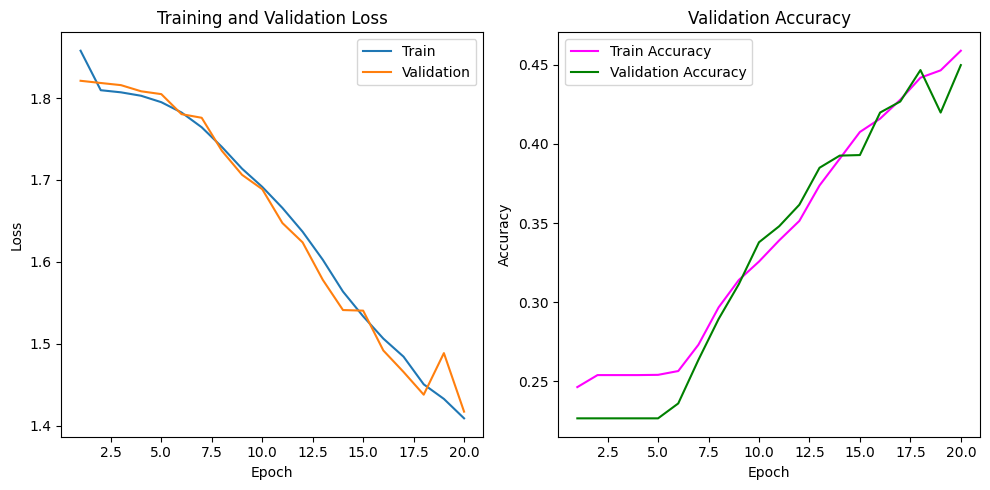

In [24]:
plot_the_graph(train_losses=train_losses,val_losses=val_losses,train_accuracies=train_accuracies,val_accuracies=val_accuracies,num_epochs=n_epochs)